
# <span style="color:rgb(213,80,0)">Run stand\-alone active material model with lithium plating</span>

This example shows how to simulate a single particle of a silicon graphite electrode, taking into account the plating phenomenon


In [1]:
clear all
close all

## Setup the properties of Li\-ion battery materials and cell design

In [2]:
jsonstruct = parseBattmoJson(fullfile('ParameterData','BatteryCellParameters','LithiumIonBatteryCell','lithium_ion_battery_nmc_graphite.json'));

inputparams = BatteryInputParams(jsonstruct);

ne      = 'NegativeElectrode';
pe      = 'PositiveElectrode';
lp      = 'LithiumPlating';
elyte   = 'Electrolyte';
thermal = 'ThermalModel';
co      = 'Coating';
am      = 'ActiveMaterial';
itf     = 'Interface';
sd      = 'SolidDiffusion';
ctrl    = 'Control';
cc      = 'CurrentCollector';

jsonstruct.use_thermal = false;
jsonstruct.include_current_collectors = false;

jsonstruct.(ne).(co).(am).diffusionModelType = 'full';
jsonstruct.(pe).(co).(am).diffusionModelType = 'full';

jsonstruct.(ne).(co).(am).useLithiumPlating = true;

% Flag for stand-alone model
jsonstruct.(ne).(co).(am).isRootSimulationModel = true;

jsonstruct_lithium_plating = parseBattmoJson(fullfile('Examples', 'Advanced', 'Plating', 'lithium_plating.json'));

jsonstruct.(ne).(co).(am).LithiumPlating = jsonstruct_lithium_plating.LithiumPlating;

scenario = 'charge';

## following is not used at particle level

In [3]:
switch scenario
  case 'charge'
    jsonstruct.Control.controlPolicy = 'CCCharge';
  case 'discharge'
    jsonstruct.Control.controlPolicy = 'CCDischarge';
  otherwise
    error('scenario not recognized');
end

% Setup InputParams
inputparams = BatteryInputParams(jsonstruct);
inputparams = inputparams.(ne).(co).(am);

%OCP is computed via a function described in the article (S-5)
inputparams.Interface.openCircuitPotential.functionname = 'computeOCP_Graphite_Latz';

## Setup the model

In [4]:
model = ActiveMaterial(inputparams);

## Equip model for simulation

In [5]:
model = model.setupForSimulation();

## Setup initial state

In [6]:
sd  = 'SolidDiffusion';
itf = 'Interface';

cElectrolyte   = 5e-1*mol/litre;
phiElectrolyte = 0;
T              = 298;

switch scenario
  case 'charge'
    % cElectrodeInit = (model.(itf).guestStoichiometry0)*(model.(itf).saturationConcentration);
    cElectrodeInit = 30*mol/litre;
  case 'discharge'
    cElectrodeInit = (model.(itf).guestStoichiometry100)*(model.(itf).saturationConcentration);
  otherwise
    error('scenario not recognized');
end

N = model.(sd).N;
initState.(sd).c        = cElectrodeInit*ones(N, 1);
initState.(sd).cSurface = cElectrodeInit;

initState.T = T;
initState.(itf).cElectrolyte   = cElectrolyte;
initState.(itf).phiElectrolyte = phiElectrolyte;

initState = model.evalVarName(initState, {itf, 'OCP'});
OCP = initState.(itf).OCP;
initState.E = OCP + phiElectrolyte;

F = model.(itf).constants.F;
R = model.(itf).constants.R;

if model.useLithiumPlating
    nPl0                 = model.LithiumPlating.nPl0;
    r                    = model.LithiumPlating.particleRadius;
    vf                   = model.LithiumPlating.volumeFraction;
    platedConcentration0 = nPl0 * vf / ((4/3)*pi*r^3);

    %initialisation so that overpotential are = 0 and reaction at equilibrium
    %at the beginning
    platedConcentrationInit = platedConcentration0/(exp((F*OCP)/(R*T)) - 1)^(1/4);

    model.(lp).platedConcentrationRef = platedConcentrationInit;

    initState.(lp).platedConcentrationNorm = platedConcentrationInit / model.(lp).platedConcentrationRef;
    initState.(lp).phiSolid            = initState.E;
    initState.(lp).phiElectrolyte      = phiElectrolyte;
    initState.(lp).cElectrolyte        = cElectrolyte;
    initState.(lp).nSEI                = 0;
end

## setup schedule

In [7]:
%This part is essential to see the lithium plating effect. Increasing Iref
%strengthen the effect.

Iref = 7e-13;
Imax = Iref;
total = 1e-3*hour*(Iref/Imax); %total time of the charge
n     = 400;
dt    = total/n;
step  = struct('val', dt*ones(n, 1), 'control', ones(n, 1));

tup = 1*second*(Iref/Imax);

switch scenario
  case 'charge'
    srcfunc = @(time) rampupControl(time, tup, -Imax);
    cmax = (model.(itf).guestStoichiometry100)*(model.(itf).saturationConcentration);
    % control.stopFunction = @(model, state, state0_inner) (state.(sd).cSurface >= cmax);
  case 'discharge'
    srcfunc = @(time) rampupControl(time, tup, Imax);
    cmin = (model.(itf).guestStoichiometry0)*(model.(itf).saturationConcentration);
    control.stopFunction = @(model, state, state0_inner) (state.(sd).cSurface <= cmin);
  otherwise
    error('scenario not recognized');
end

% uncomment to make the simulation run without current (debugging)
% srcfunc = @(time) 0;

control.src = srcfunc;

schedule = struct('control', control, 'step', step);

scalingparams = struct('I'                  , Imax                              , ...
                       'elyteConcentration' , initState.(itf).cElectrolyte);

if model.useLithiumPlating
    scalingparams.platedConcentration = platedConcentrationInit;
end

model = model.setupScalings(scalingparams);

## setup non\-linear solver

In [8]:
nls = NonLinearSolver();
nls.errorOnFailure  = false;
nls.maxTimestepCuts = 20;

model.nonlinearTolerance = 1e-6;

## Run simulation by charging the particle

In [9]:
model.verbose = true;
[~, states, report] = simulateScheduleAD(initState, model, schedule, 'OutputMinisteps', true, 'NonLinearSolver', nls);

## Then discharge it

In [10]:
%Comment this part to only see the charge

%We use the last state of the previous simulation to initialise the new one
initstate = states{end};
jsonstruct.(ctrl).DRate = -1;
jsonstruct.Control.controlPolicy = 'CCDischarge';

% And we save the charging states for later

chargeStates = states;

% Setup schedule

% Set up a StopFunction if necessary
% Control.stopFunction = @(model, state, state0_inner) (1 == 0);

srcfunc = @(time) rampupControl(time, tup, Imax);

control.src = srcfunc;

schedule = struct('control', control, 'step', step);

% Run simulation

[~, states, report] = simulateScheduleAD(initstate, model, schedule, 'OutputMinisteps', true, 'NonLinearSolver', nls);

In [11]:

% And concatenate the states

dischargeStates = states;
states = vertcat(chargeStates, dischargeStates);

## Plot


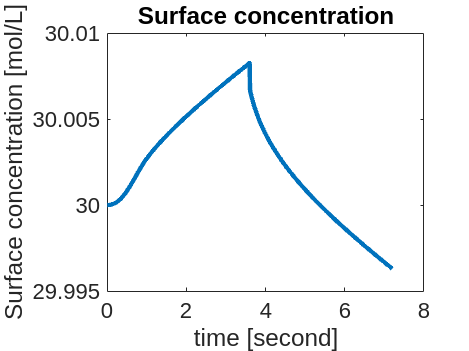

In [12]:
ind = cellfun(@(state) ~isempty(state), states);
states = states(ind);

time     = cellfun(@(state) state.time, states);
cSurface = cellfun(@(state) state.(sd).cSurface, states);
E        = cellfun(@(state) state.E, states);

figure
plot(time, cSurface/(1/litre));
xlabel('time [second]');
ylabel('Surface concentration [mol/L]');
title('Surface concentration');


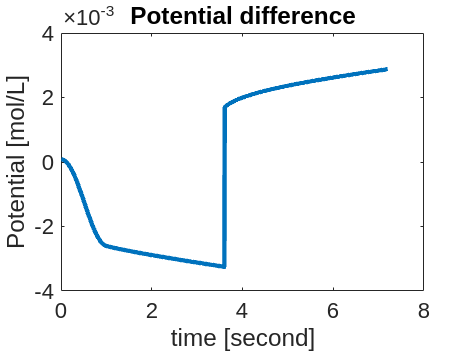

In [13]:

figure
plot(time, E);
xlabel('time [second]');
ylabel('Potential [mol/L]');
title('Potential difference');

In [14]:

cmin = cellfun(@(state) min(state.(sd).c), states);
cmax = cellfun(@(state) max(state.(sd).c), states);

for istate = 1 : numel(states)
    states{istate} = model.evalVarName(states{istate}, {sd, 'cAverage'});
end

## Lithium plating plotting


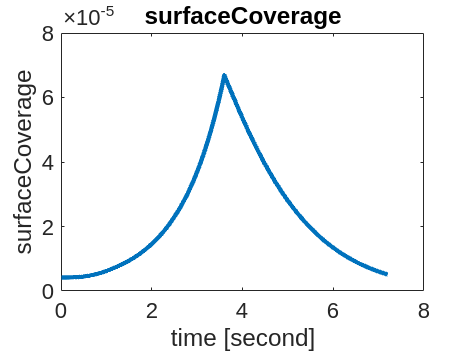

In [15]:
lp = 'LithiumPlating';

varsToEval = {{'Interface'     , 'eta'}         , ...
              {'LithiumPlating', 'etaPlating'}  , ...
              {'LithiumPlating', 'etaChemical'} , ...
              {'Interface'     , 'intercalationFlux'}           , ...
              {'LithiumPlating', 'platingFlux'} , ...
              {'LithiumPlating', 'chemicalFlux'}, ...
              {'LithiumPlating', 'surfaceCoverage'}, ...
              {'LithiumPlating', 'platedThickness'}};
for k = 1:numel(states)
    for var = 1:numel(varsToEval)
        states{k} = model.evalVarName(states{k}, varsToEval{var});
    end
end

varnames = {
            'platedConcentration', ...
            'eta', ...
            'etaPlating', ...
            'etaChemical', ...
            'platingFlux', ...
            'chemicalFlux', ...
            'intercalationFlux', ...
            'surfaceCoverage', ...
            'platedThickness'};

vars = {};

vars{end + 1} = cellfun(@(s) s.(lp).platedConcentration, states);
vars{end + 1} = cellfun(@(s) s.(itf).eta, states);
vars{end + 1} = cellfun(@(s) s.(lp).etaPlating, states);
vars{end + 1} = cellfun(@(s) s.(lp).etaChemical, states);
vars{end + 1} = cellfun(@(s) s.(lp).platingFlux .* s.(lp).surfaceCoverage, states);
vars{end + 1} = cellfun(@(s) s.(lp).chemicalFlux .* s.(lp).surfaceCoverage, states);
vars{end + 1} = cellfun(@(s) s.(itf).intercalationFlux .* (1 - s.(lp).surfaceCoverage), states);
vars{end + 1} = cellfun(@(s) s.(lp).surfaceCoverage, states);
vars{end + 1} = cellfun(@(s) s.(lp).platedThickness, states);

%
% for ivar = 5 : numel(varnames)
%     figure
%     plot(time, vars{ivar}, '-');
%     xlabel('time [second]');
%     ylabel(varnames{ivar});
%     title(varnames{ivar});
%     dim = [0.7 0.1 0.2 0.2]; % Position and size of the annotation box [x, y, width, height] (normalized)
%     str = sprintf('n = %.2f\nT = %.2f\nIref = %.2e', n, T, Iref);
%     annotation('textbox', dim, 'String', str, 'EdgeColor', 'black', 'BackgroundColor', [1 1 1], 'FontSize', 10);
% end
%

% Variable : surfaceCoverage
figure
plot(time, vars{8}, '-');
xlabel('time [second]');
ylabel(varnames{8});
title(varnames{8});


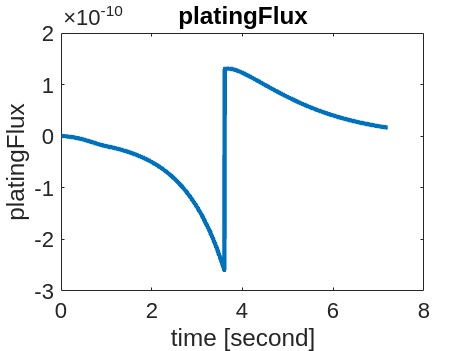

In [16]:
% Area fraction that is plated. The more lithium is plated, the less it can
% pass from the electrolyte to intercalate into the electrode. Thus, if
% surfaceCoverage = 1, no more lithium can be intercalated from the solution.
% The electrode can still be filled with plated lithium through the
% chemical flux

% Variable : platingFlux .* surfaceCoverage
figure
plot(time, vars{5}, '-');
xlabel('time [second]');
ylabel(varnames{5});
title(varnames{5});


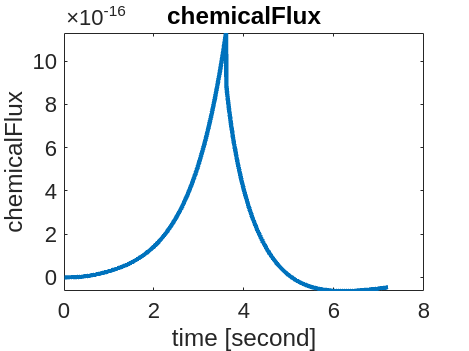

In [17]:
% We can see clearly here the 4 differents steps of the lithium plating phenomenon.
% First, at the end of the charge, the amount of lithium being plated grows
% faster and faster as the area where plating is possible increases.
%
% Then, as the plated lithium covers the whole particle, the plating flux stabilises.
%
% At the beginning of the discharge, the plated lithium begins to strip, as
% the plated layer is the only electron source available (the intercalated
% lithium has no contact with the electrolyte)

% Finally, the surfaceCoverage decreases, resulting in a slower stripping.

% Variable : chemicalFlux .* surfaceCoverage
figure
plot(time, vars{6}, '-');
xlabel('time [second]');
ylabel(varnames{6});
title(varnames{6});


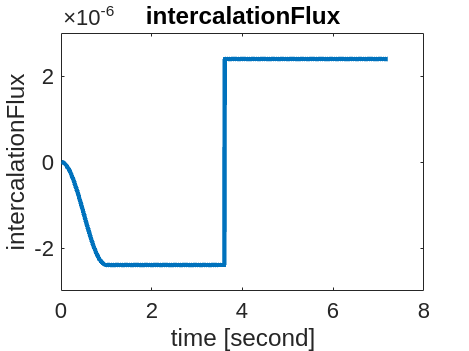

In [18]:
% TODO: Ajouter commentaire ici pour le flux chimique

% Variable : intercalationFlux .* (1 - surfaceCoverage)
figure
plot(time, vars{7}, '-');
xlabel('time [second]');
ylabel(varnames{7});
title(varnames{7});


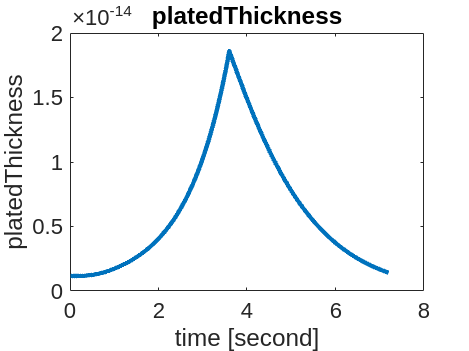

In [19]:
% No more lithium is intercalated during the time the whole surface is covered
% with plated lithium.


% Variable : platedThickness
figure
plot(time, vars{9}, '-');
xlabel('time [second]');
ylabel(varnames{9});
title(varnames{9});


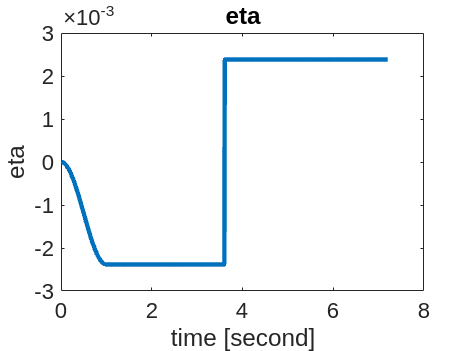

In [20]:
% TODO: Ajouter commentaire ici pour l'épaisseur du dépôt

figure
plot(time, vars{2}, '-');
xlabel('time [second]');
ylabel(varnames{2});
title(varnames{2});


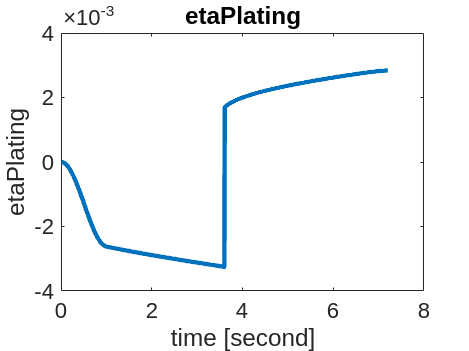

In [21]:

figure
plot(time, vars{3}, '-');
xlabel('time [second]');
ylabel(varnames{3});
title(varnames{3});